In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [2]:
import re
import os

In [3]:
from multiprocessing import Pool
from itertools import repeat

In [4]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
# plt.rc("text", usetex=True)

In [5]:
def load_edge_data(eventID):
    edge_data = np.load("./edge_data/CR{}_stacked_edge.npy".format(eventID))
    simID_data = np.load("./edge_data/CR{}_SimID4edge.npy".format(eventID))
    
    all_sims = []
    
    for s in simID_data:
        mm = re.search("run\d\d\d_AWSoM2T", s)
        all_sims.append(int(mm.group().split("run")[1].split("_")[0]))
    
    return edge_data, np.array(all_sims)

In [6]:
ed_2161, sd_2161 = load_edge_data(2161)
ed_2192, sd_2192 = load_edge_data(2192)
ed_2154, sd_2154 = load_edge_data(2154)

In [7]:
nTimes = ed_2161.shape[0]
nTimes

90

In [8]:
nTheta_2161 = ed_2161.shape[1]
nTheta_2192 = ed_2192.shape[1]
nTheta_2154 = ed_2154.shape[1]
nTheta_2161, nTheta_2192, nTheta_2154

(200, 185, 400)

In [9]:
nSims_2161 = ed_2161.shape[2]
nSims_2192 = ed_2192.shape[2]
nSims_2154 = ed_2154.shape[2]
nSims_2161, nSims_2192, nSims_2154

(278, 231, 141)

**Event: Start, End(x out of 512)**

CR2154: 50, 450

CR2161: 160,360

CR2192: 90, 275

So the actual angle(suppose (0,1)i s 0 and (1,0) is 90 and so forth) will be 360/512 * x + 1.2 * 180 - 360. Note that, 1.2pi is coming from function Normalization, in which I start at x+1.2pi counterclockwise.Here's an example, for CR2161, the actual angle will be seq(0,360, by = 360/512)[160:359]+1.2*180 - 360 which is equal to [-32, 107]

In [10]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[359] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

theta_s_2192, theta_e_2192 = np.linspace(0, 360, 512)[90] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[274] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2192, theta_e_2192))

theta_s_2154, theta_e_2154 = np.linspace(0, 360, 512)[50] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[449] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2154, theta_e_2154))

Range of angles for CR2161: -31.279843444227026 108.91585127201563
Range of angles for CR2161: -80.59491193737767 49.03326810176122
Range of angles for CR2161: -108.77495107632095 172.32093933463796


In [17]:
height_flattened=128

In [18]:
actualTimes = np.arange(2, 182, 2)

In [19]:
def plot_edge_data(Z, titleSim, eventID=2161, plotAll=False, ax=None, theta=np.linspace(-32, 107, 200)):
    """Visualize edges data in space and time both in polar and original Cartesian coordinates."""
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot a few snapshots over the spatial domain.
    if plotAll:
        sample_columns = [i for i in range(Z.shape[1])]
    else:
        sample_columns = [0, 2, 4, 8, 12, 20, 40, 50, 60, 70, 74, 80, 84, 88, 89]
        
    sample_times = actualTimes[sample_columns]
    color = iter(plt.cm.viridis(np.linspace(0, 1, len(sample_columns))))
    while sample_columns[-1] > Z.shape[1]:
        sample_columns.pop()
    for i, j in enumerate(sample_columns):
        ax.plot(theta, Z[:, j], color=next(color), label=fr"$u(t_{{{sample_times[i]}}})$")

    ax.set_xlabel(r"$theta (deg)$")
    ax.set_ylabel(r"$r_{edge}(t)$")
    
    ax.set_xlim(theta[0], theta[-1])
    ax.set_yticks(np.arange(0, height_flattened, step=21), labels=['4R', '7R', '10R', '13R', '16R', '19R', '24R'])
    ax.legend(loc=(1.05, .05))
    ax.set_title("Edge data Sim {:03d}".format(titleSim))

In [20]:
    # commenting out save functionality for now!!
    #     plt.savefig(os.path.join(edge_save_dir, "CR{}".format(eventID), "run_{:03d}.png".format(titleSim)),
    #                bbox_inches="tight", pad_inches=0)

    #     print("Saved image for Event {} Sim {:03d}".format(eventID, titleSim))

    #     plt.close()

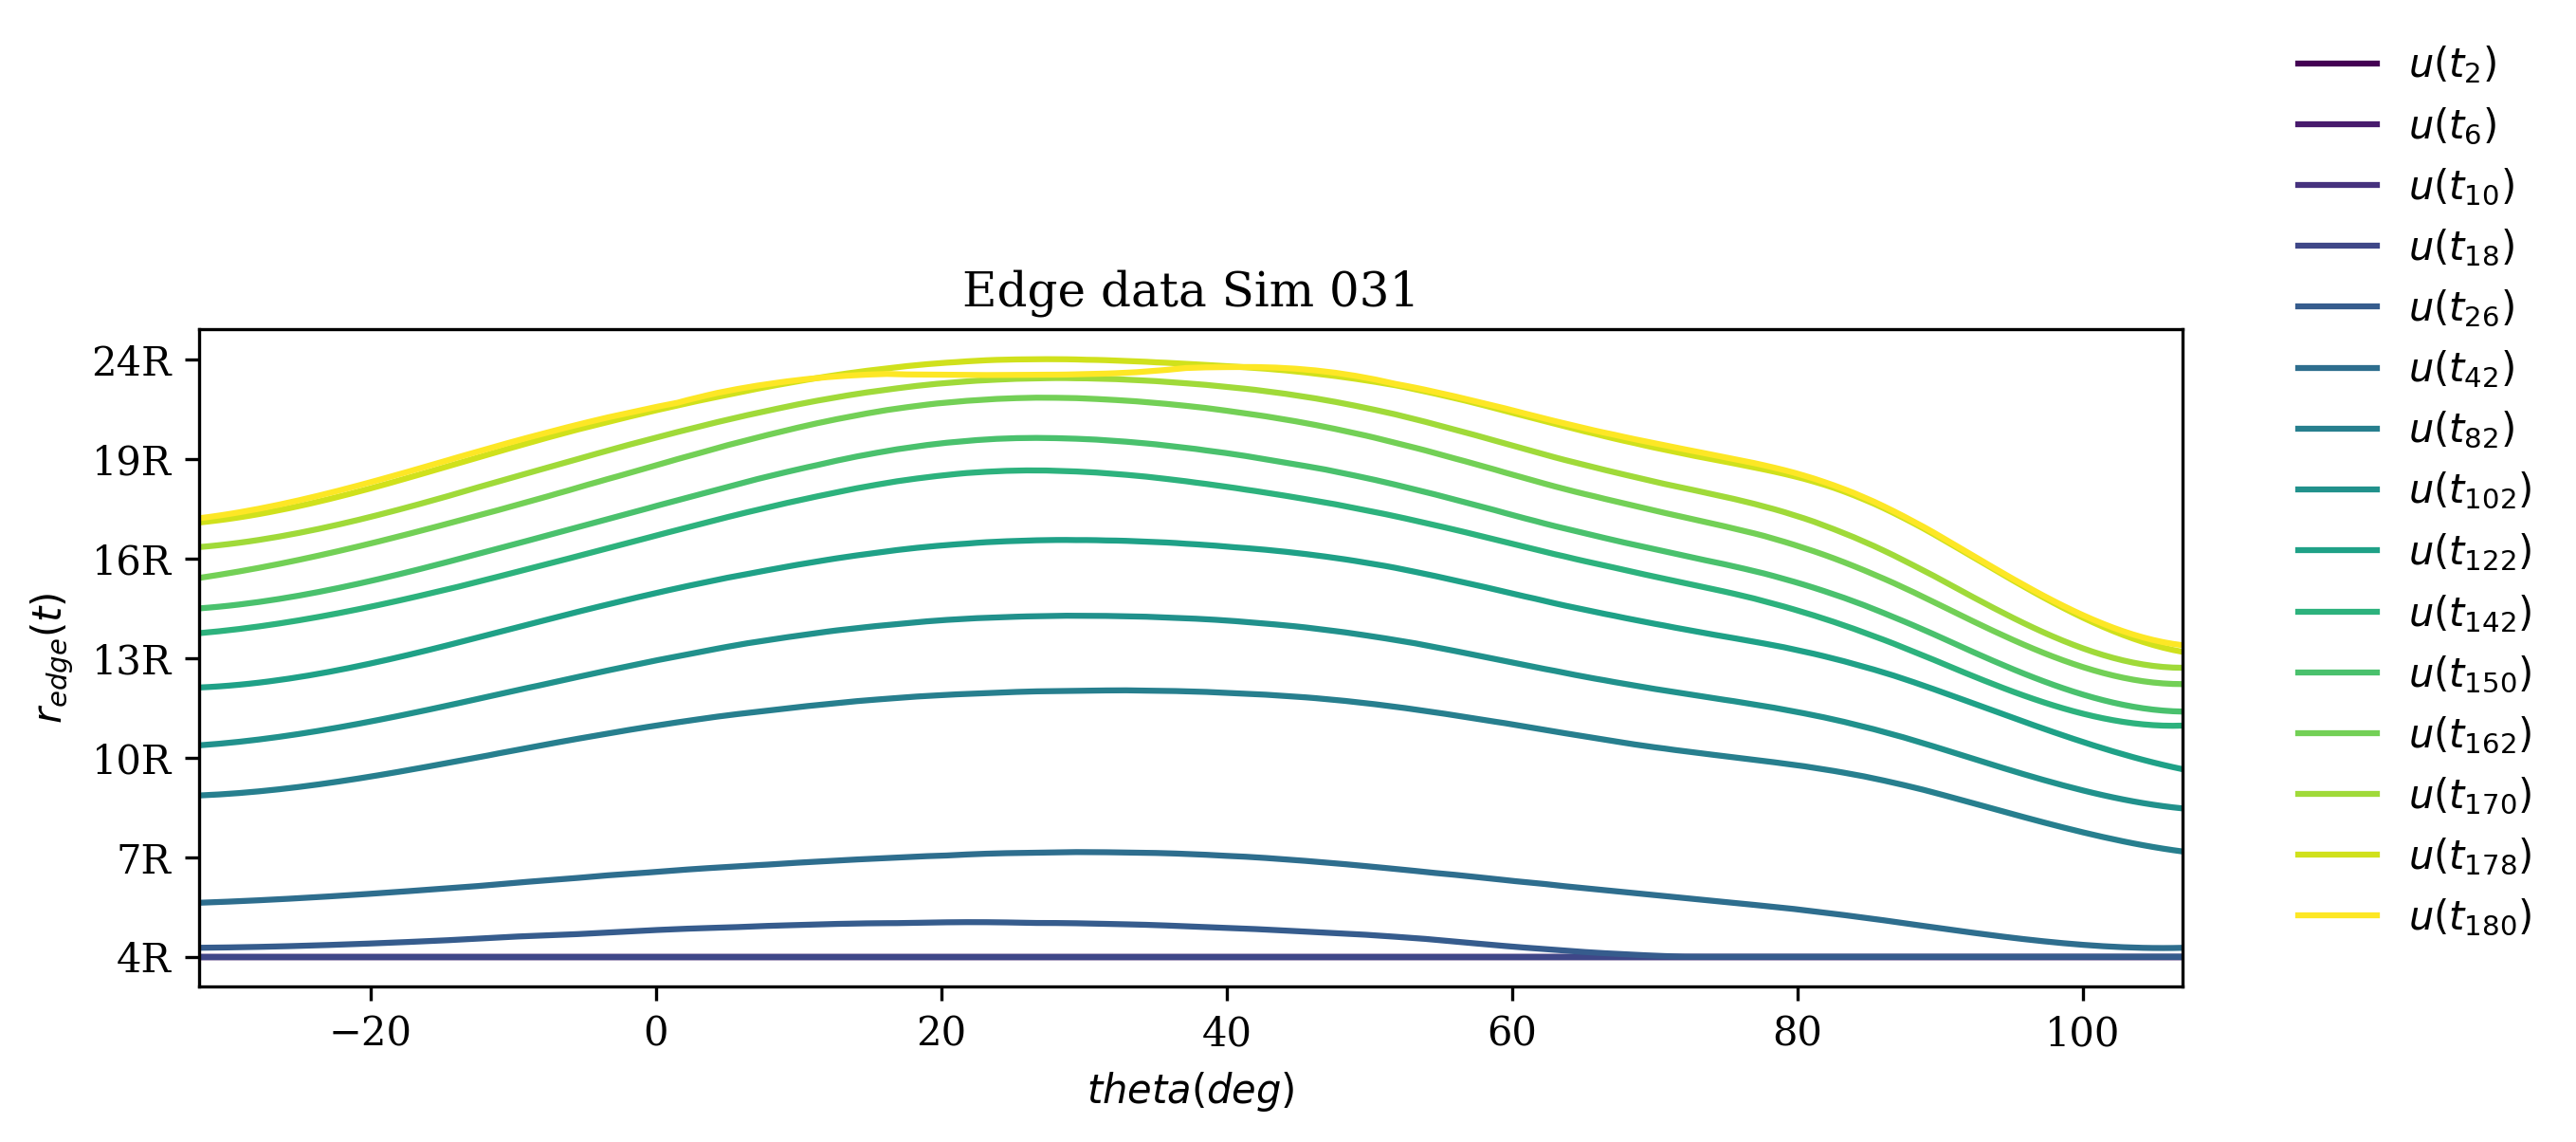

In [21]:
plot_edge_data(ed_2161[:, :, 0].T, 31, eventID=2161, plotAll=False, ax=None, theta=np.linspace(-32, 107, 200))

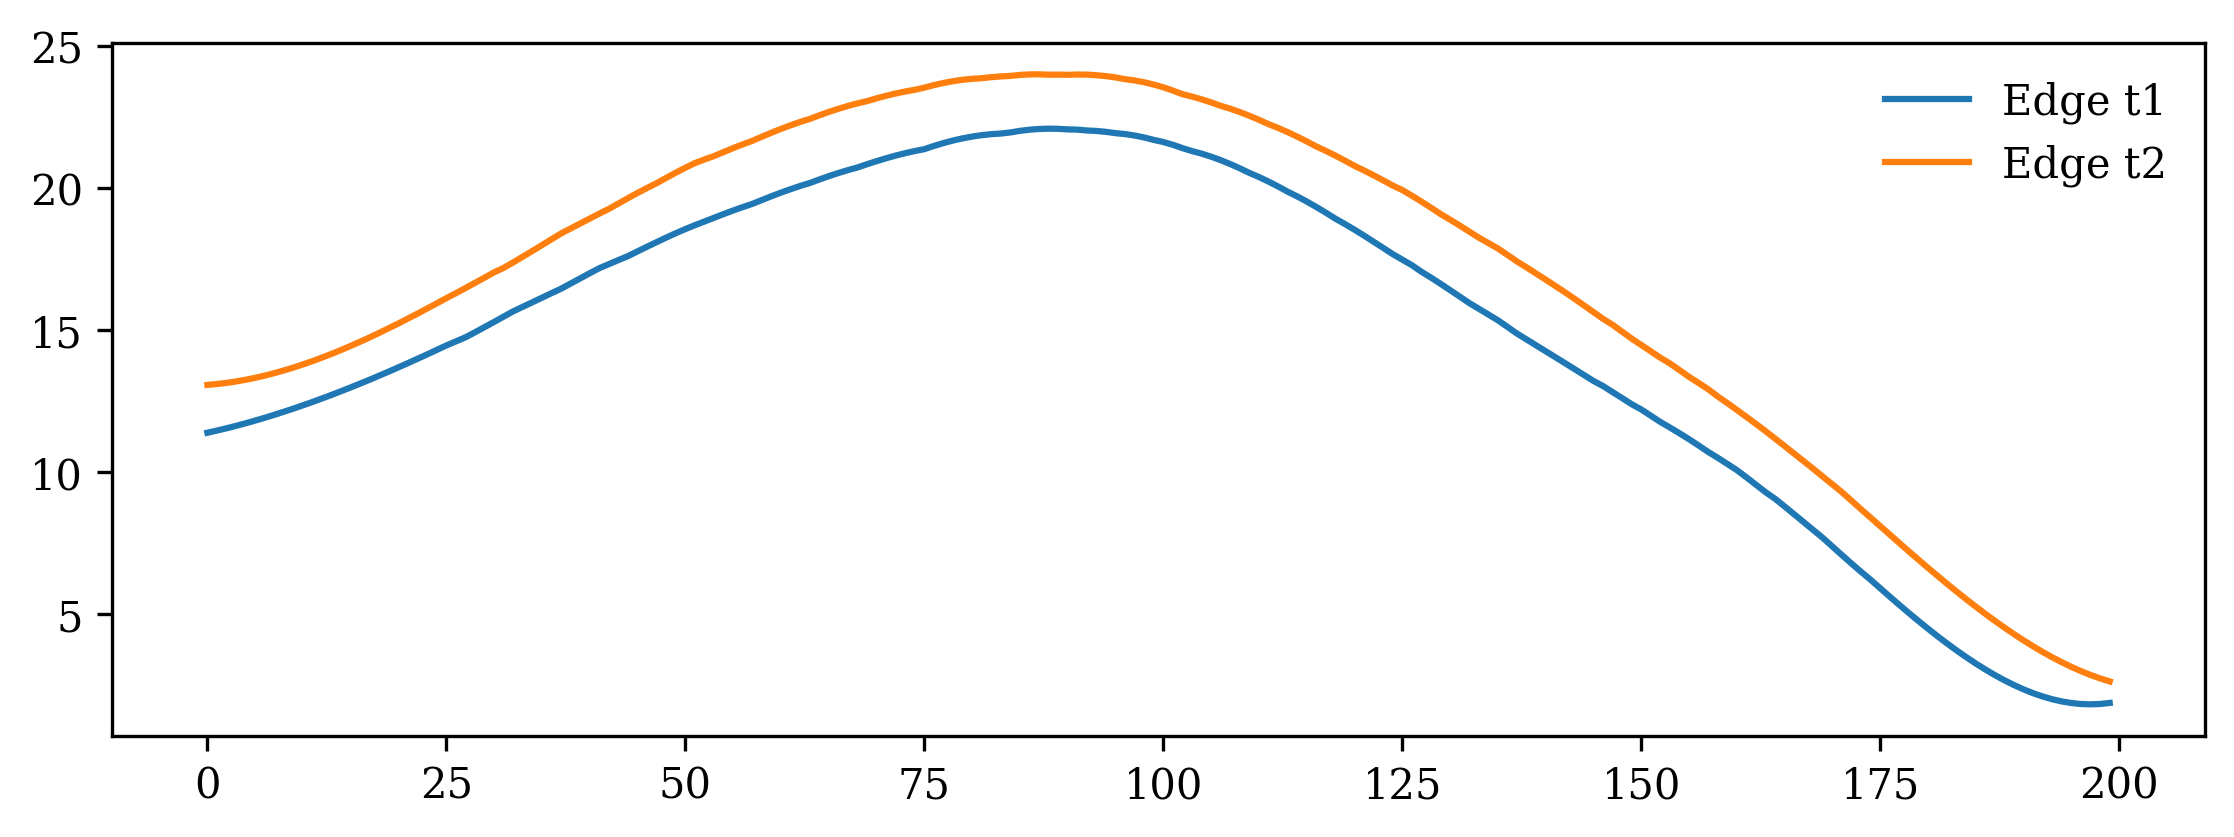

In [24]:
edge1 = ed_2161[20, :, 0]
edge2 = ed_2161[21, :, 0]

plt.plot(edge1, label="Edge t1")
plt.plot(edge2, label="Edge t2")
plt.legend()

In [25]:
ed31 = ed_2161[:, :, 0]

In [27]:
min_edge_by_time = np.min(ed31, axis=1)

In [28]:
tMinIdx = np.where(min_edge_by_time > 0)[0][0]
tMinIdx

20

In [29]:
tMin = np.linspace(2, 180, 90)[tMinIdx]
tMin

42.0

Now set the values of selected points $(r/t)$ using `tMin` as a reference.

In [30]:
theta_samples = np.linspace(-32, 107, 200)[0:-1:2]
theta_all = np.linspace(-32, 107, 200)

In [31]:
r_by_t_ref = ed31[tMinIdx, 0:-1:2]/tMin

In [32]:
t2 = tMin + 2
t2

44.0

In [33]:
r2_exact = r_by_t_ref * t2

In [34]:
r2_all = ed31[tMinIdx + 1, :]

In [35]:
r_by_t_calc = ed31[tMinIdx + 1, 0:-1:2]/(tMin + 2)

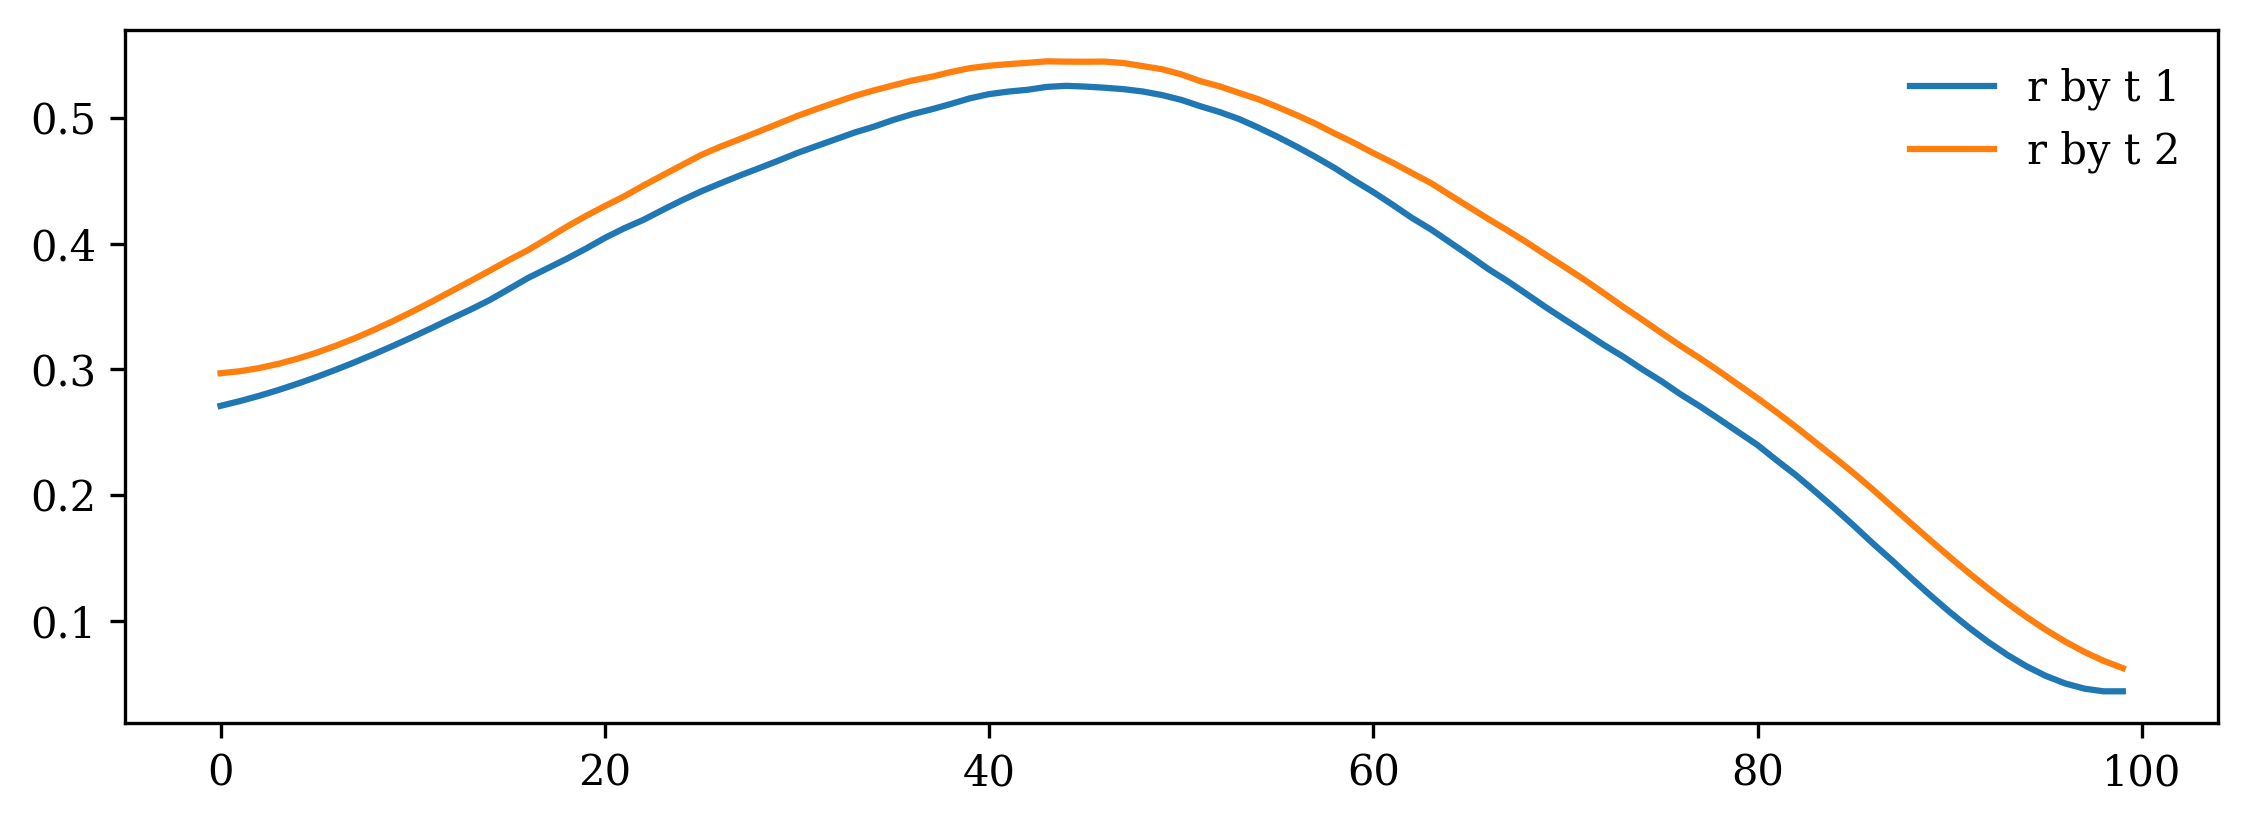

In [36]:
plt.plot(r_by_t_ref, label="r by t 1")
plt.plot(r_by_t_calc, label="r by t 2")
plt.legend()

Also try another scaling.

In [37]:
r_by_sqrt_t_ref = ed31[tMinIdx, 0:-1:2]/np.sqrt(tMin)
r_by_sqrt_t_calc = ed31[tMinIdx + 1, 0:-1:2]/np.sqrt(tMin + 2)

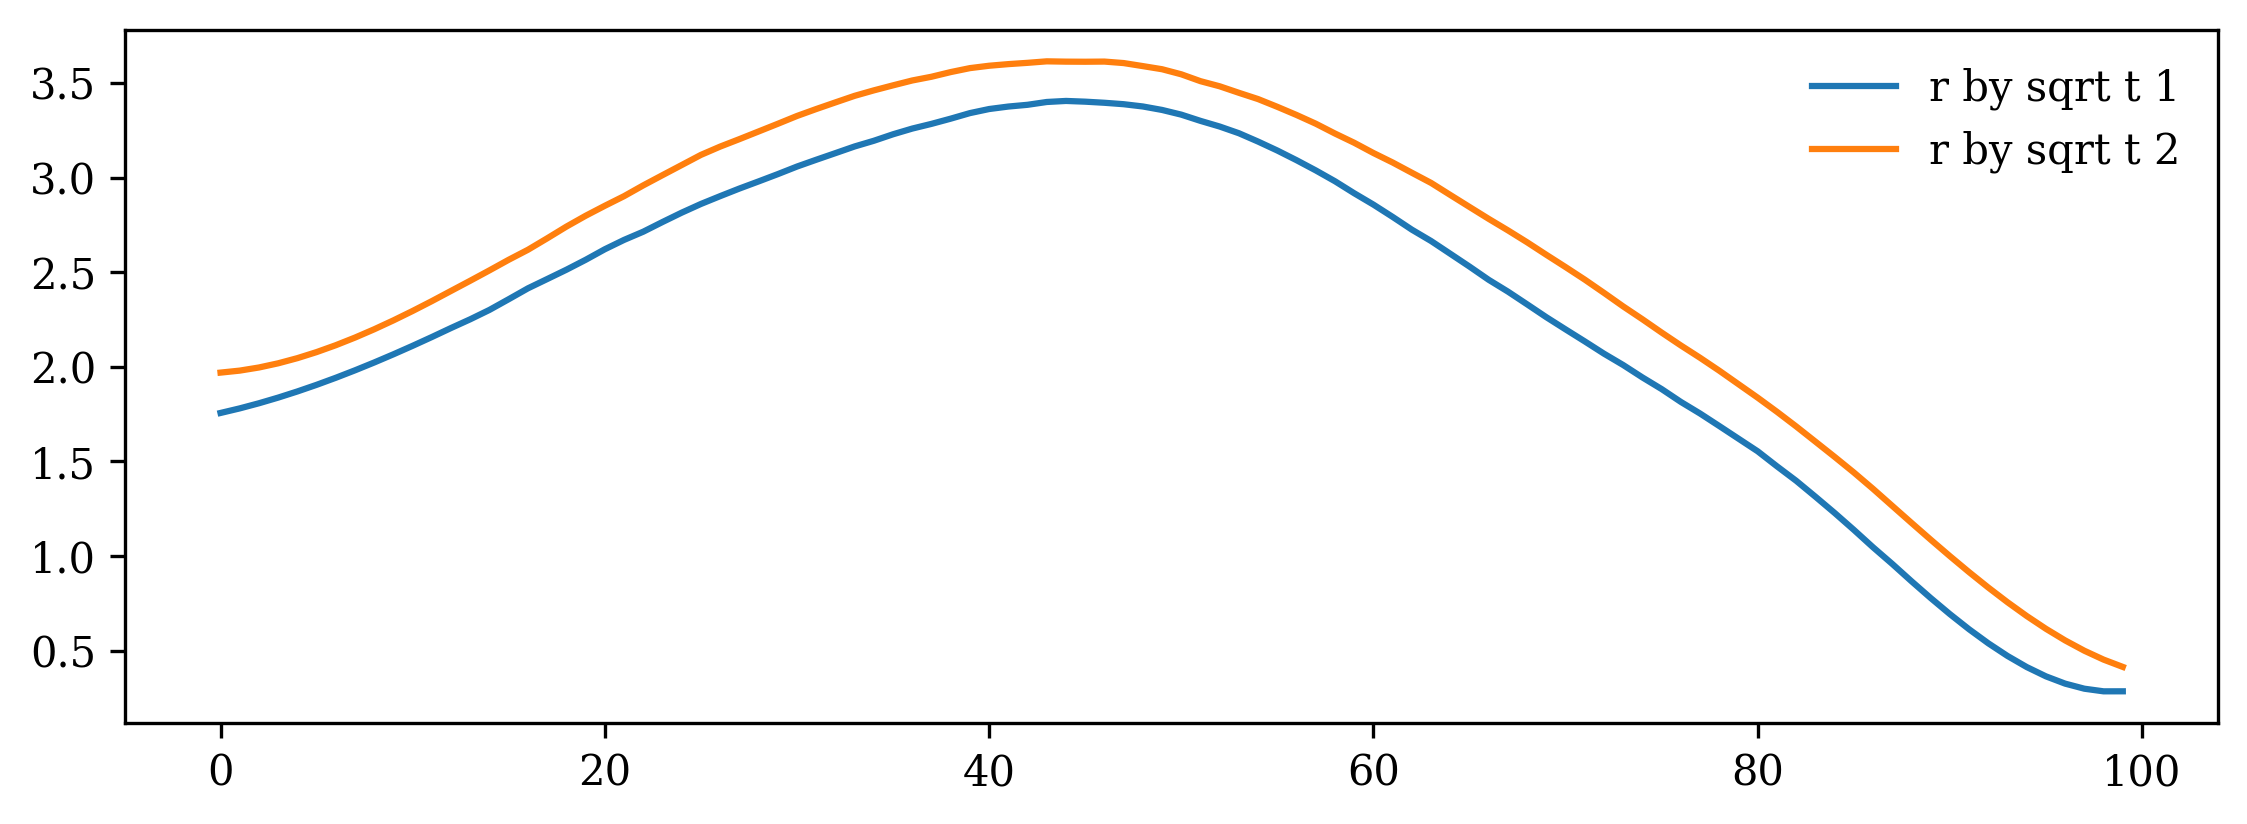

In [38]:
plt.plot(r_by_sqrt_t_ref, label="r by sqrt t 1")
plt.plot(r_by_sqrt_t_calc, label="r by sqrt t 2")
plt.legend()

In [22]:
# convert pixel values to Cartesian, then get correct R and theta values from there. Show on a polar plot!

**Event: Start, End(x out of 512)**

CR2154: 50, 450

CR2161: 160,360

CR2192: 90, 275

So the actual angle(suppose (0,1)i s 0 and (1,0) is 90 and so forth) will be 360/512 * x + 1.2 * 180 - 360. Note that, 1.2pi is coming from function Normalization, in which I start at x+1.2pi counterclockwise.Here's an example, for CR2161, the actual angle will be seq(0,360, by = 360/512)[160:359]+1.2*180 - 360 which is equal to [-32, 107]

In [41]:
def Polar_to_Cartesian(edge, start_angle, end_angle, height, width, circles_disk, circles_scope):
    theta = np.arange(0, 2 * np.pi, 2 * np.pi / width)[start_angle:end_angle]
    # Coordinates of disk and telescope center
    circle_x = circles_disk[0]
    circle_y = circles_disk[1]
    # Radius of disk and telescope
    r_disk = circles_disk[2]
    r_scope = circles_scope[2]
    Xp = circle_x + r_disk * np.cos(theta + 1.2 * np.pi)
    Yp = circle_y + r_disk * np.sin(theta + 1.2 * np.pi)
    Xi = circle_x + r_scope * np.cos(theta + 1.2 * np.pi)
    Yi = circle_y + r_scope * np.sin(theta + 1.2 * np.pi)
    r = edge / height
    X = Xp + ( Xi - Xp ) * r
    Y = Yp + ( Yi - Yp ) * r
    return (X,Y)

In [46]:
X1, Y1 = Polar_to_Cartesian(edge1, 
                   start_angle = 160, 
                   end_angle = 360, 
                   height=128, 
                   width=512, 
                   circles_disk=(149,149,19), 
                   circles_scope=(149,149,110))

In [45]:
X2, Y2 = Polar_to_Cartesian(edge2, 
                   start_angle = 160, 
                   end_angle = 360, 
                   height=128, 
                   width=512, 
                   circles_disk=(149,149,19), 
                   circles_scope=(149,149,110))

In [48]:
X1_norm, Y1_norm = (64 * (X1/300) - 32), (64 * (Y1/300) - 32)
X2_norm, Y2_norm = (64 * (X2/300) - 32), (64 * (Y2/300) - 32)

In [49]:
R1, theta1 = np.sqrt(X1_norm**2 + Y1_norm**2), np.arctan2(Y1_norm, X1_norm)
R2, theta2 = np.sqrt(X2_norm**2 + Y2_norm**2), np.arctan2(Y2_norm, X2_norm)

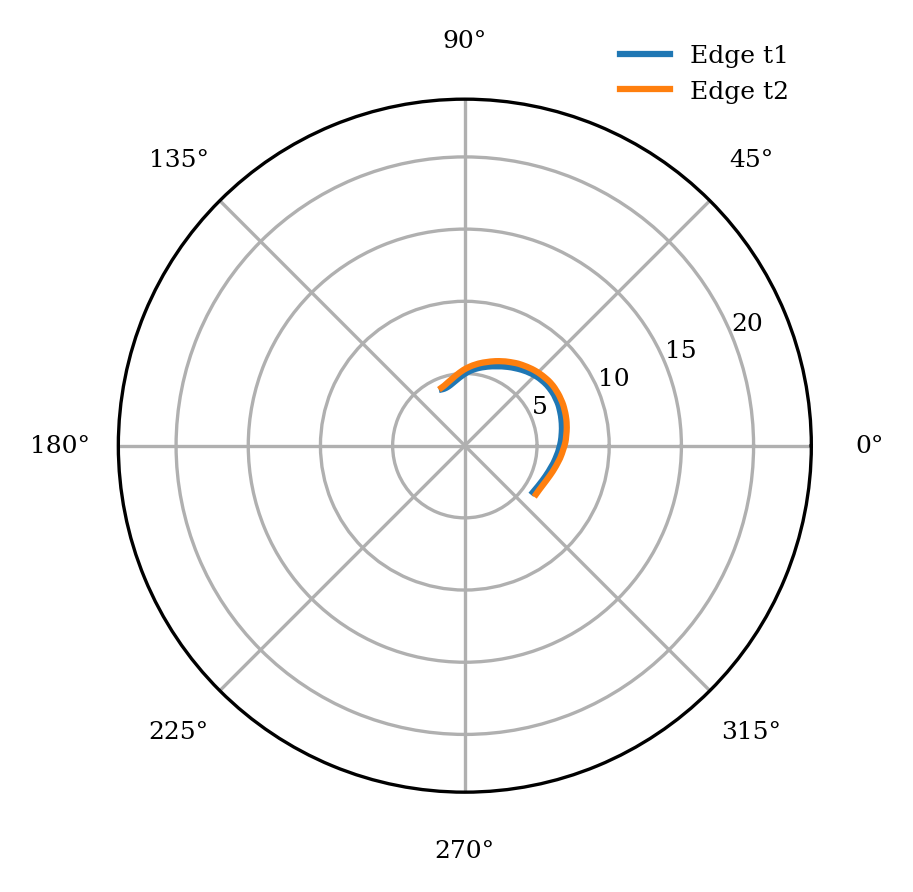

In [65]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta1, R1, linewidth=1.5, label="Edge t1")
ax.plot(theta2, R2, linewidth=1.5, label="Edge t2")
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_rmax(24)
ax.grid(True)
# For polar axes, it may be useful to move the legend slightly away from the
# axes center, to avoid overlap between the legend and the axes.  The following
# snippet places the legend's lower left corner just outside the polar axes
# at an angle of 67.5 degrees in polar coordinates.
angle = np.deg2rad(67.5)
ax.legend(loc="lower left",
          prop={'size': 6},
          bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))

Also plot the above on a regular Cartesian plot (unlike the previous ones, this one will have R as the y-axis!)

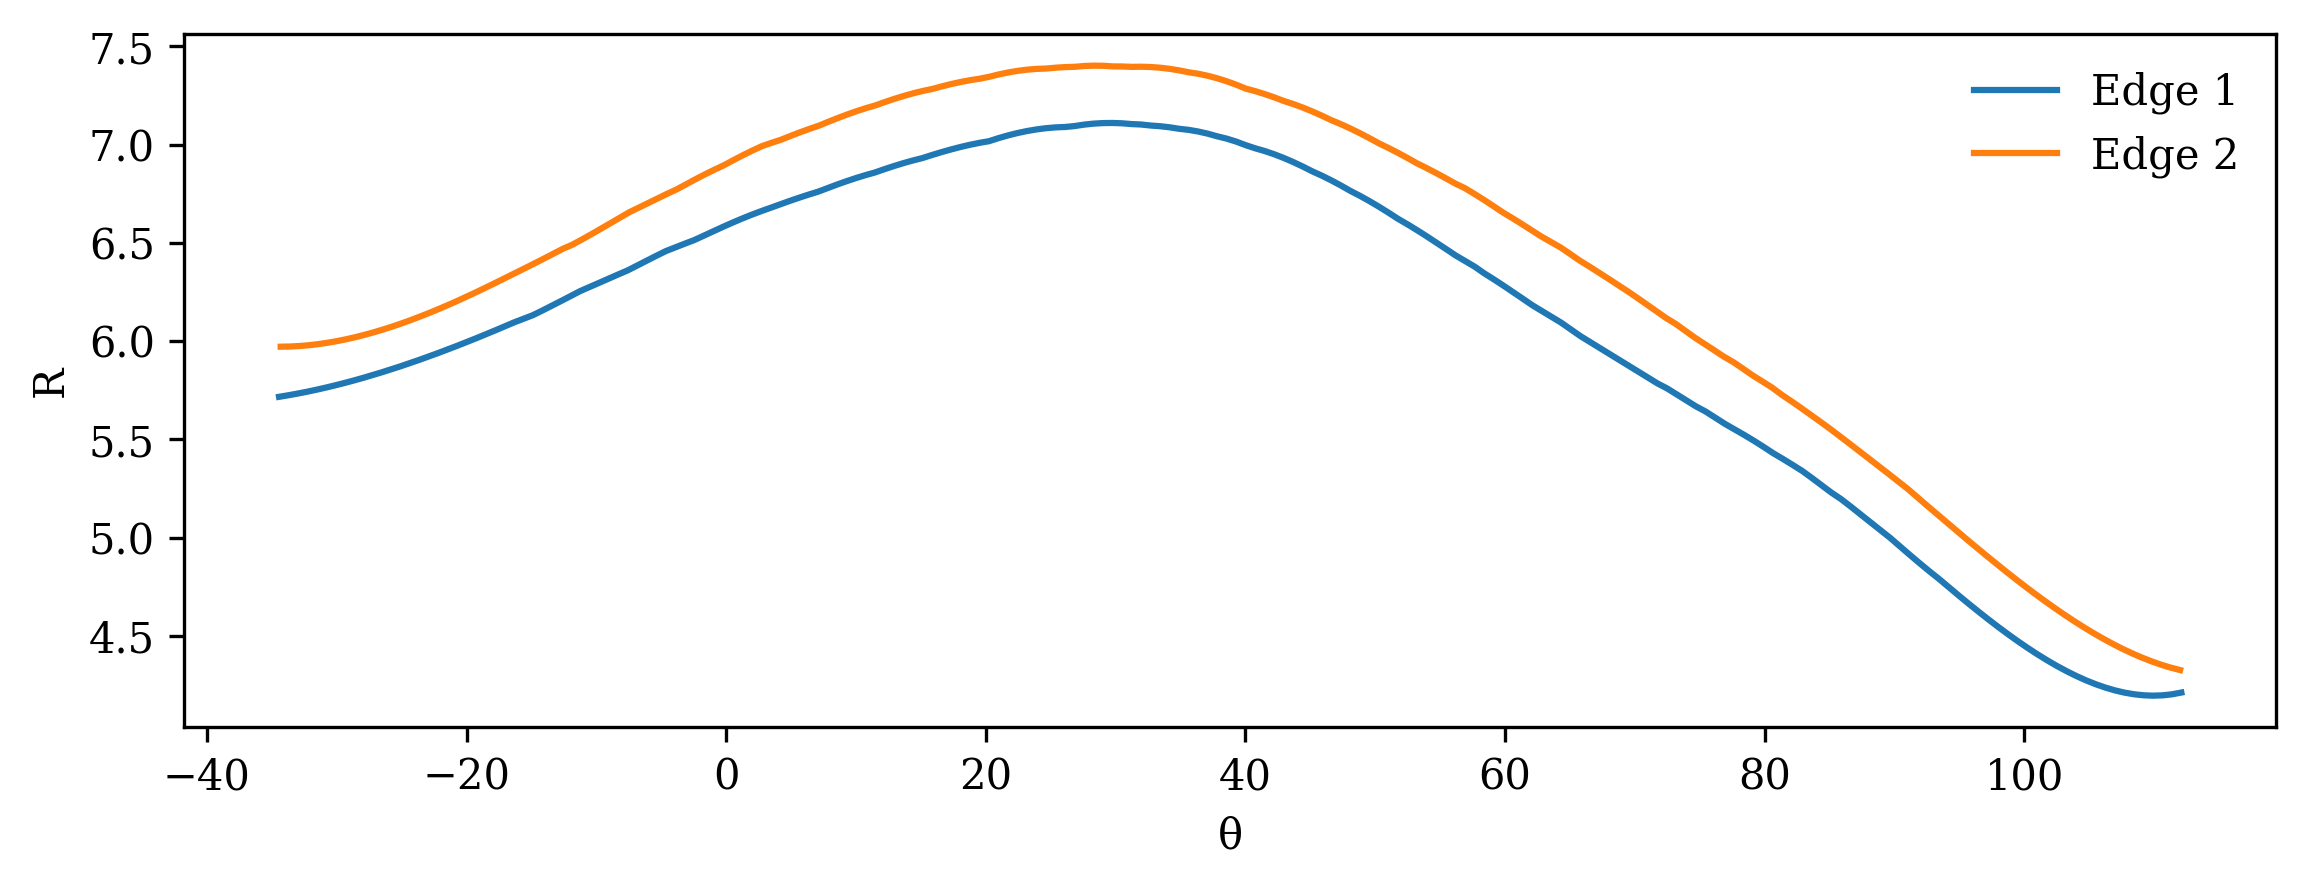

In [67]:
plt.plot(theta1 * 180 / np.pi, R1, label="Edge 1")
plt.plot(theta2 * 180 / np.pi, R2, label="Edge 2")
plt.xlabel("θ")
plt.ylabel("R")
plt.legend()

Now rerun the polar conversion for all the edges. Make a side by side plot for visualization first. We can also set the $\theta$ values to a common range as we had already prespecified. For now arguments like start and end angle are event-specific.

In [92]:
def getRValues(edge_data_matrix, simIdx=0, minStartIdx=20):
    
    edges_sim = edge_data_matrix[minStartIdx:, :, simIdx]
    
    nTimes, nThetas = edges_sim.shape[0], edges_sim.shape[1]
    
    r_vals = np.zeros((nTimes, nThetas))
    theta_vals = np.zeros((nTimes, nThetas))
    
    for i in range(nTimes):
        xi, yi   = Polar_to_Cartesian(edges_sim[i, :], 
                   start_angle = 160, 
                   end_angle = 360, 
                   height=128, 
                   width=512, 
                   circles_disk=(149,149,19), 
                   circles_scope=(149,149,110))
        
        xi_norm, yi_norm = 64 * (xi/300) - 32, 64 * (yi/300) - 32
        theta_vals[i, :] = np.arctan2(yi_norm, xi_norm)
    
        r_vals[i, :] = np.sqrt(xi_norm**2 + yi_norm**2)
    
    return r_vals, theta_vals

In [93]:
r_vals_s31, theta_vals_s31 = getRValues(ed_2161, simIdx=0, minStartIdx = 20)

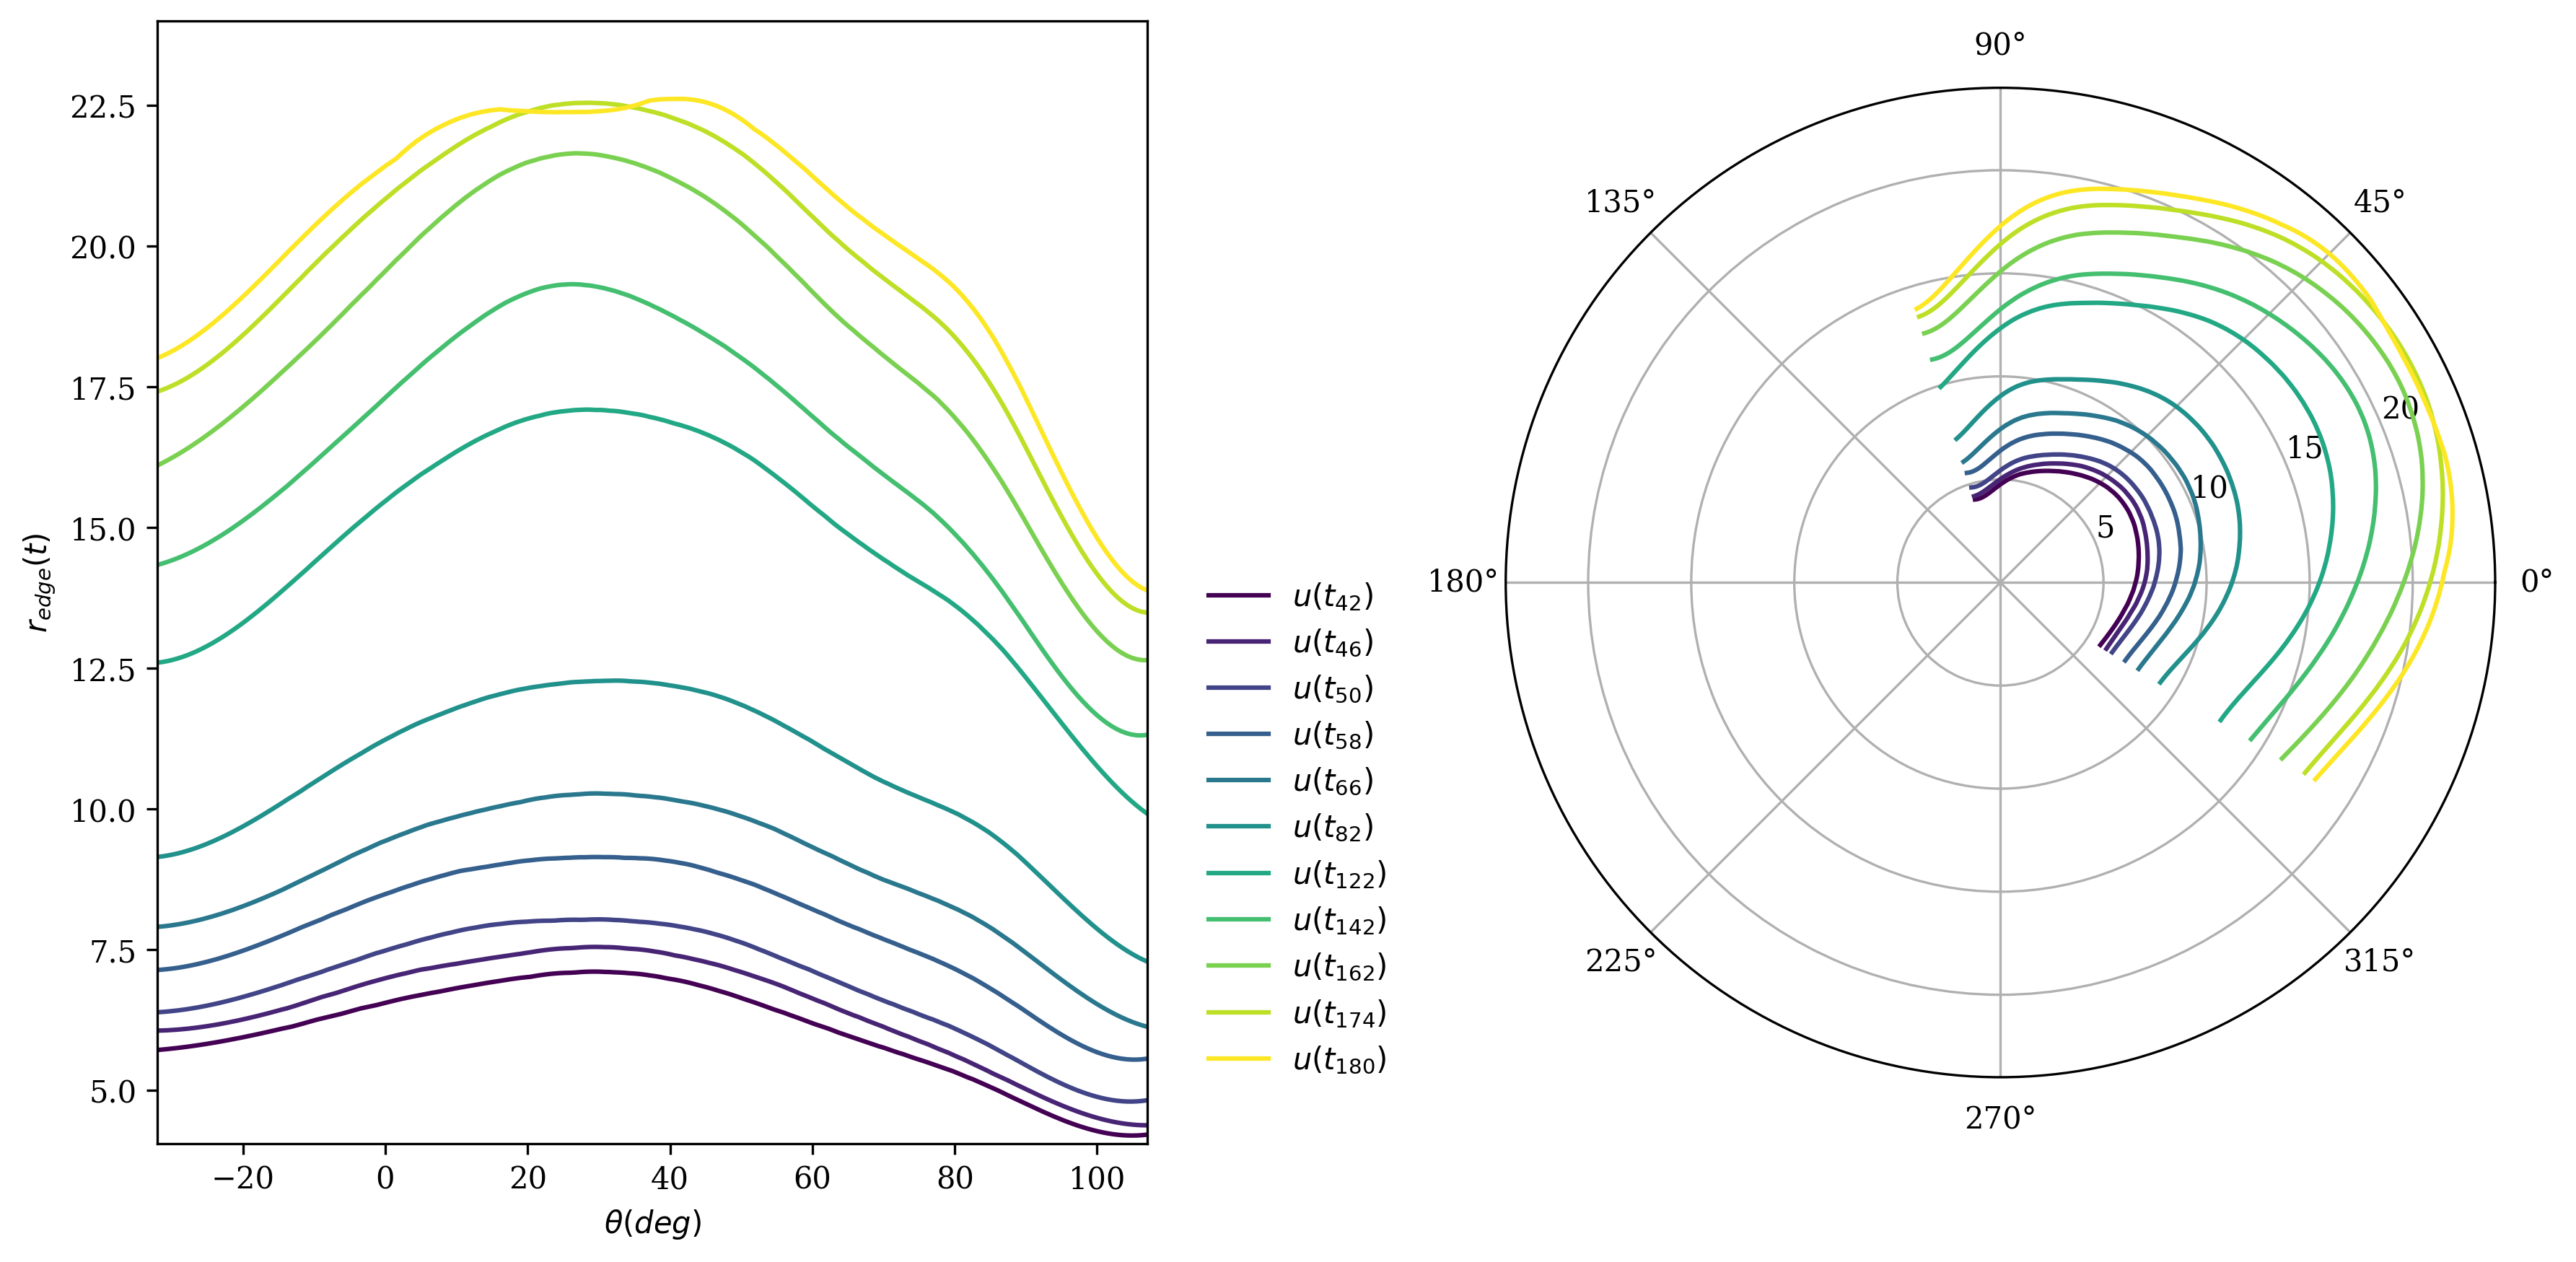

In [97]:
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

sampleTimeIdx = [0, 2, 4, 8, 12, 20, 40, 50, 60, 66, 69]
sampleTimesToPlot = actualTimes[20:][sampleTimeIdx]

color = iter(plt.cm.viridis(np.linspace(0, 1, len(sampleTimesToPlot))))

theta = np.linspace(-32, 107, 200)

for i, j in enumerate(sampleTimeIdx):
    ax1.plot(theta, r_vals_s31[j, :], color=next(color), label=fr"$u(t_{{{sampleTimesToPlot[i]}}})$")

ax1.set_xlabel(r"$θ (deg)$")
ax1.set_ylabel(r"$r_{edge}(t)$")
ax1.set_xlim(-32, 107)
ax1.set_ylim(4.05, 24)
ax1.legend(loc=(1.05, .05))

color = iter(plt.cm.viridis(np.linspace(0, 1, len(sampleTimesToPlot))))


for i, j in enumerate(sampleTimeIdx):
    ax2.plot(theta * np.pi/180, r_vals_s31[j, :], color=next(color), label=fr"$u(t_{{{sampleTimesToPlot[i]}}})$")


ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_rmax(24)
ax2.grid(True)


fig.tight_layout()

Visualize matching of rescaled points with Dynamic Time Warping and see if we can get a unique correspondence?

**Proper Orthogonal Decomposition**?

SOpInf style, we could shift and scale first, but then the drawback is that the shift learning process is not explicitly parametrized? Maybe then the shifting problem could just be treated separately, i.e.

**Model 1**: Given new $\theta^\ast$, predict $c(\theta^\ast)$ based on training set

**Model 2**: Predict $\hat{f}(\theta^\ast, r/t)$ and then shift back to advection coordinates (add $c(\theta^\ast) \times t$) to get $f(\theta^\ast, r, t)$

**Non linear dimensionality Reduction - Diffusion Maps?**

[Coifman and Lafon, 2006 - Diffusion Maps](https://doi.org/10.1016/j.acha.2006.04.006)

[Winstead, 2017, Nonlinear MOR based on Manifold Learning](https://trace.tennessee.edu/cgi/viewcontent.cgi?article=5535&context=utk_gradthes)